Importing

In [311]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.animation import FuncAnimation
import scienceplots
import scipy as sp
from scipy.integrate import odeint

Creating the function for the ODE

In [312]:
def model(z, t, betaD, betaR, v, n, m, k, M):
    D = z[:k]
    R = z[k:2*k]
    D_n = M@z[:k]
    dDdT = v * (betaD / (1 + R**n) - D)
    dRdt = betaR * D_n**m / (1 + D_n**m) - R
    return np.ravel([dDdT, dRdt])

Finding the Neighbours for each cell

In [313]:
def get_connectivity_matrix(P, Q, w):
    k = P * Q  # number of cells
    M = np.zeros((k, k))  # connectivity matrix

    # calculating the connectivity matrix
    for s in range(k):
        kneighbor = find_neighbor_hex(s, P, Q)
        for r in range(6):
            M[s-1, kneighbor[r]-1] = w
    np.fill_diagonal(M, 0)
    return M

def find_neighbor_hex(ind, P, Q):
    # This function finds the 6 neighbors of cell ind
    p, q = ind2pq(ind, P)

    # above and below:
    out = [
        pq2ind((p % P) + 1, q, P),
        pq2ind((p - 2) % P + 1, q, P),
        # left and right sides:
        pq2ind(p if q % 2 != 0 else (p % P) + 1, (q - 2) % Q + 1, P),
        pq2ind((p - 2) % P + 1 if q % 2 != 0 else p, (q - 2) % Q + 1, P),
        pq2ind(p if q % 2 != 0 else (p % P) + 1, q % Q + 1, P),
        pq2ind((p - 2) % P + 1 if q % 2 != 0 else p, q % Q + 1, P)
    ]
    return out

def pq2ind(p, q, P):
    return p + (q - 1) * P

def ind2pq(ind, P):
    q = 1 + ((ind - 1) // P)
    p = ind - (q - 1) * P
    return p, q

Setting up the parameters

In [314]:
t = np.linspace(0, 30, 300)
n = 3
m = 3
P = 10
Q = 10
k = P * Q
w = 1/6
betaD = 10
betaR = 10
v = 1
M = get_connectivity_matrix(P, Q, w)
M

array([[0.        , 0.16666667, 0.        , ..., 0.        , 0.        ,
        0.16666667],
       [0.16666667, 0.        , 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.16666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.16666667,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16666667, 0.        ,
        0.16666667],
       [0.16666667, 0.        , 0.        , ..., 0.        , 0.16666667,
        0.        ]])

Initial conditions

In [315]:
D0 = 1e-5 * np.random.random((1, k))
R0 = np.zeros((1, k))
z0 = np.ravel([D0, R0])

Solving the ODE

In [316]:
z = odeint(model, z0, t, args=(n, m, betaD, betaR, v, k, M))
D = z[:, :k]
R = z[:, k:2*k]
z

array([[9.09032667e-06, 8.95497657e-06, 4.08872259e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.90004994e+00, 1.90004989e+00, 1.90004810e+00, ...,
        1.40059950e-01, 1.40059841e-01, 1.40059897e-01],
       [2.59669630e+00, 2.59669629e+00, 2.59669563e+00, ...,
        3.26275527e-01, 3.26275417e-01, 3.26275473e-01],
       ...,
       [8.30286911e-03, 3.00000000e+00, 8.28718993e-03, ...,
        1.65183310e+00, 1.04647994e+00, 5.04920809e-01],
       [8.30274301e-03, 3.00000000e+00, 8.28718881e-03, ...,
        1.65181893e+00, 1.04649984e+00, 5.04846300e-01],
       [8.30262249e-03, 3.00000000e+00, 8.28718780e-03, ...,
        1.65180527e+00, 1.04651903e+00, 5.04774423e-01]])

Plotting Concentrations

Text(0.5, 0.98, 'Lateral Inhibition Model for a Grid of Cells')

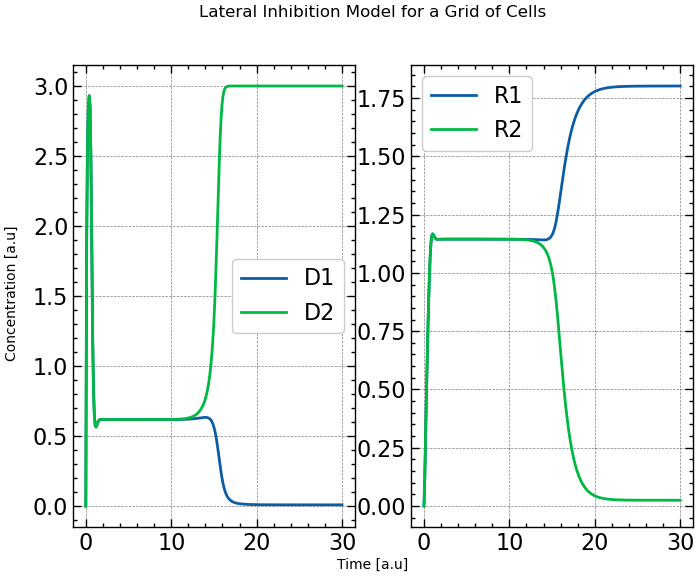

In [317]:
plt.style.use(['science', 'notebook', 'grid'])
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(8, 6))
ax[0].plot(t, D[:, :2])
# lst1 = []
# for i in range(2*k):
#     lst1.append("D"+str(i))
ax[0].legend(['D1', 'D2'])
ax[1].plot(t, R[:, :2])
# lst2 = []
# for j in range(2*k):
#     lst2.append("R"+str(j))
ax[1].legend(['R1', 'R2'])
fig.text(0.5, 0.04, 'Time [a.u]', ha='center')
fig.text(0.04, 0.5, 'Concentration [a.u]', va='center', rotation='vertical')
fig.suptitle('Lateral Inhibition Model for a Grid of Cells')
# plt.show()

Plotting Hexagons

In [318]:
def plot_hexagon(p0, q0, c):
    s32 = np.sqrt(3) / 4
    q = q0 * 3 / 4
    p = p0 * 2 * s32
    if q0 / 2 == round(q0 / 2):
        p = p + s32

    x = [q - 0.5, q - 0.25, q + 0.25, q + 0.5, q + 0.25, q - 0.25]
    y = [p, p + s32, p + s32, p, p - s32, p - s32]

    plt.fill(x, y, c, linewidth=2)

def movie_lattice(tout, yout, P, Q, k):
    Cmax = np.max(yout[-1, :k])
    fig = plt.figure()

    def animate(tind):
        plt.clf()
        for i in range(P):
            for j in range(Q):
                ind = pq2ind(i + 1, j + 1, P)
                mycolor = min(yout[tind, ind] / Cmax, 1)
                plot_hexagon(i + 1, j + 1, [1 - mycolor, 1 - mycolor, 1])
        plt.axis('image')
        plt.axis('off')

    anim = FuncAnimation(fig, animate, frames=range(0, len(tout), 5), interval=200)
    plt.show()
movie_lattice(t, z, P, Q, k)

<Figure size 800x600 with 0 Axes>